# Multi-Class Classification of RetinaMNIST Dataset with CNN Model¶

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')


Mounted at /content/drive


## Import Libraries

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns




In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Load Dataset

In [5]:
#data = np.load('/content/drive/MyDrive/mnist_medical_images/retinamnist.npz')
data = np.load('/data/retinamnist.npz')
print(data.files)  # shows stored arrays like ['images', 'labels']

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


.npz file contains a split dataset

In [6]:
# Extract arrays
x_train = data['train_images']
y_train = data['train_labels']
x_val   = data['val_images']
y_val   = data['val_labels']
x_test  = data['test_images']
y_test  = data['test_labels']

In [7]:
# check shapes
print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)


Train: (1080, 28, 28, 3) (1080, 1)
Val:   (120, 28, 28, 3) (120, 1)
Test:  (400, 28, 28, 3) (400, 1)


## Analyze Dataset

In [8]:
#See unique labels and their counts
# Combine all labels to see full label space
all_labels = np.concatenate([y_train, y_val, y_test])

# Get unique classes and their counts
unique_labels, counts = np.unique(all_labels, return_counts=True)
print("Unique labels:", unique_labels)
print("Counts per label:", dict(zip(unique_labels, counts)))

Unique labels: [0 1 2 3 4]
Counts per label: {np.uint8(0): np.int64(714), np.uint8(1): np.int64(186), np.uint8(2): np.int64(326), np.uint8(3): np.int64(282), np.uint8(4): np.int64(92)}


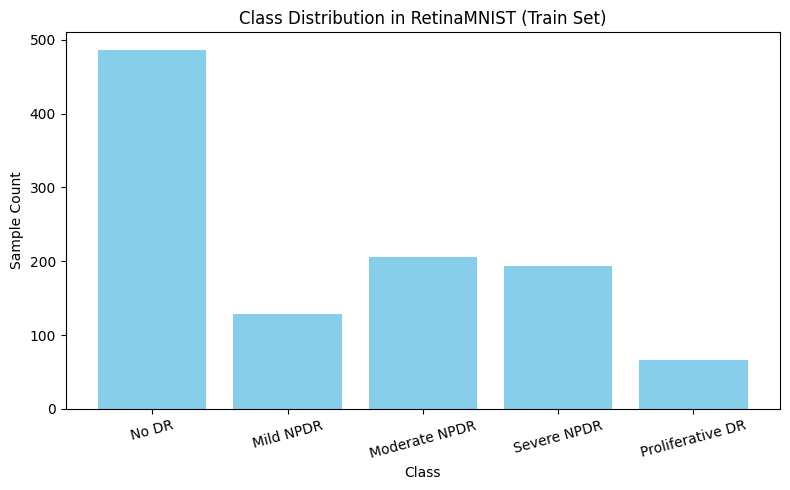

In [9]:
# Count occurrences of each class
class_names = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR']
unique, counts = np.unique(y_train, return_counts=True)

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts, color='skyblue')
plt.title("Class Distribution in RetinaMNIST (Train Set)")
plt.xlabel("Class")
plt.ylabel("Sample Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

There are 5 distinct classes, labeled 0 through 4.


*   class 0 has 714 samples
*   class 1 has 186 samples
*   class 2 has 326 samples
*   class 3 has 282 samples
*   class 4 has 92 samples







According to the MedMNIST paper and docs, RetinaMNIST is a 5-class classification of fundus images for diabetic retinopathy:



Label ->	Class
0	- No DR
1	- Mild NPDR (non-proliferative)
2	- Moderate NPDR
3	- Severe NPDR
4	- Proliferative DR

(“DR” = Diabetic Retinopathy)





0 → healthy retina

1–4 → increasing severity of diabetic retinopathy

In [10]:
# Create a mapping for labels
label_map = {
    0: 'No DR',
    1: 'Mild NPDR',
    2: 'Moderate NPDR',
    3: 'Severe NPDR',
    4: 'Proliferative DR'
}


<ipython-input-14-ad0d3ee07b22>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # ensure int


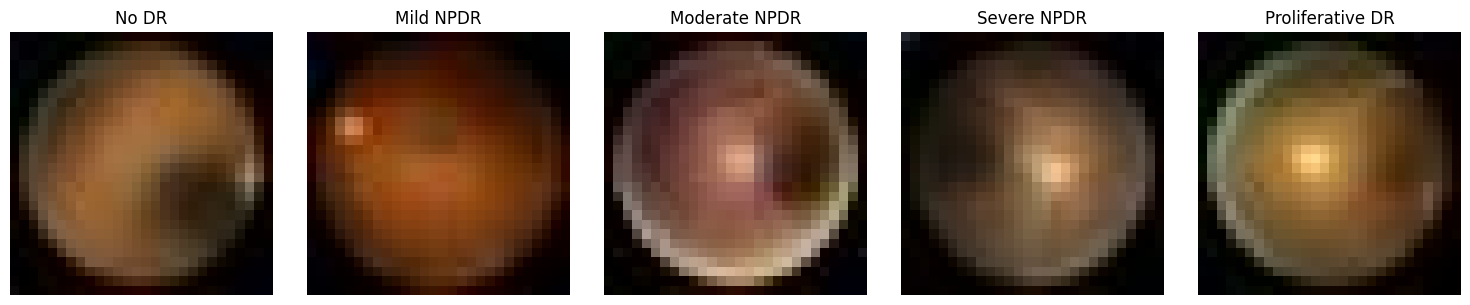

In [14]:
# Visualize a Grid of Sample Images per Label


num_classes = len(label_map)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3)) # Set up grid: 1 row, 5 columns (1 image per class)

# Track shown labels
shown = set()

for i, (img, label) in enumerate(zip(x_train, y_train)):
    label = int(label)  # ensure int
    if label not in shown:
        ax = axes[label]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(label_map[label])
        ax.axis('off')
        shown.add(label)
    if len(shown) == num_classes:
        break

plt.tight_layout()
plt.show()


## Data Pre-Processing

In [15]:
# Normalize data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [16]:
# One-hot encode the labels
from tensorflow.keras.utils import to_categorical


y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)


## **Apply Class-Balanced Augmentation**

1. Identifies minority classes

2. Augments their samples using ImageDataGenerator

3. Adds augmented samples to the original dataset

4. Shuffles everything into a balanced training set

In [17]:
# Convert one-hot labels back to class indices
y_train_labels = np.argmax(y_train, axis=1)

# Identify minority classes (below mean count)
unique, counts = np.unique(y_train_labels, return_counts=True)
print(f"unique =        {list(unique)}")
print(f"counts =        {list(counts)}")


mean_count = np.mean(counts)
print(f"mean_count =    {mean_count:.1f}")

unique =        [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
counts =        [np.int64(486), np.int64(128), np.int64(206), np.int64(194), np.int64(66)]
mean_count =    216.0


In [18]:
minority_classes = [cls for cls, cnt in zip(unique, counts) if cnt < mean_count]
print(f"minority_classes = {minority_classes}")

minority_classes = [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [19]:
# Augment minority class samples
augmentor = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05
)

augmented_images, augmented_labels = [], []
target_per_class = int(mean_count)

for cls in minority_classes:
    cls_indices = np.where(y_train_labels == cls)[0]
    x_cls = x_train[cls_indices]
    y_cls = y_train[cls_indices]

    gen = augmentor.flow(x_cls, y_cls, batch_size=1)
    for _ in range(target_per_class - len(x_cls)):
        x_aug, y_aug = next(gen)  # get 1 augmented image + label
        augmented_images.append(x_aug[0]) # append the image to the list
        augmented_labels.append(y_aug[0])  # append the one-hot label


In [20]:
# Convert and combine
x_augmented = np.array(augmented_images)
y_augmented = np.array(augmented_labels)

x_train_balanced = np.concatenate([x_train, x_augmented], axis=0)
y_train_balanced = np.concatenate([y_train, y_augmented], axis=0)

# Shuffle
indices = np.arange(x_train_balanced.shape[0])
np.random.shuffle(indices)
x_train_balanced = x_train_balanced[indices]
y_train_balanced = y_train_balanced[indices]

In [21]:
print(f'x_train_balanced shape: {x_train_balanced.shape}')

x_train_balanced shape: (1350, 28, 28, 3)


## Define Model

In [22]:

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 output classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,965 (878.77 KB)

 Trainable params: 224,965 (878.77 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [23]:
#  Train Without Augmentation
history_no_aug = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)



Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4026 - loss: 1.4385 - val_accuracy: 0.4500 - val_loss: 1.2774
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4407 - loss: 1.2889 - val_accuracy: 0.4500 - val_loss: 1.1720
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4762 - loss: 1.2810 - val_accuracy: 0.4667 - val_loss: 1.1186
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4747 - loss: 1.2146 - val_accuracy: 0.6083 - val_loss: 1.1450
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4747 - loss: 1.2064 - val_accuracy: 0.5750 - val_loss: 1.0955
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4835 - loss: 1.1981 - val_accuracy: 0.5500 - val_loss: 1.1570
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5073 - loss: 1.1791 - val_accuracy: 0.4667 - val_loss: 1.1002
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4763 - loss: 1.1708 - val_accuracy: 0.4917 - v

In [24]:
 # Train With Augmentation

# Use same model architecture for augmented data by cloning previous model
model_aug = tf.keras.models.clone_model(model)
model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_aug = model_aug.fit(
    x_train_balanced,
    y_train_balanced,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3259 - loss: 1.5419 - val_accuracy: 0.4583 - val_loss: 1.3531
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4156 - loss: 1.4004 - val_accuracy: 0.3917 - val_loss: 1.2626
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3994 - loss: 1.3918 - val_accuracy: 0.4667 - val_loss: 1.1662
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4321 - loss: 1.3448 - val_accuracy: 0.3833 - val_loss: 1.2490
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4451 - loss: 1.2988 - val_accuracy: 0.4833 - val_loss: 1.1599
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4489 - loss: 1.3113 - val_accuracy: 0.5333 - val_loss: 1.1053
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4692 - loss: 1.2841 - val_accuracy: 0.4250 - val_loss: 1.1270
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4805 - loss: 1.2394 - val_accuracy: 0.4750 - v

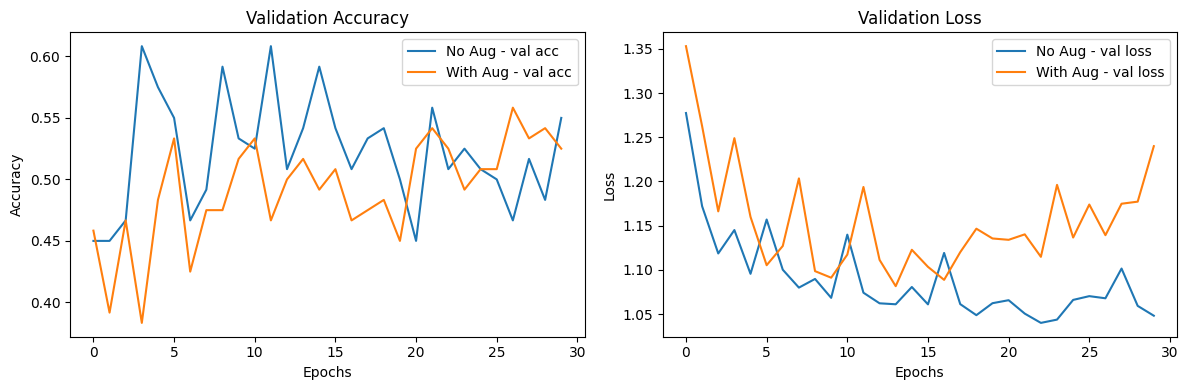

In [25]:
# Compare Performance (Accuracy & Loss)

import matplotlib.pyplot as plt

def plot_training(history1, history2, label1="No Aug", label2="With Aug"):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_accuracy'], label=f'{label1} - val acc')
    plt.plot(history2.history['val_accuracy'], label=f'{label2} - val acc')
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_loss'], label=f'{label1} - val loss')
    plt.plot(history2.history['val_loss'], label=f'{label2} - val loss')
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot it!
plot_training(history_no_aug, history_aug)


# **Evaluation (No Augmentation)**

In [33]:
# Evaluate model on test set
results = model.evaluate(x_test, y_test)
print("Test results:", results)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5817 - loss: 1.1583
Test results: [1.2301640510559082, 0.5450000166893005]


In [34]:
# Predict probabilities
y_pred_probs_no_aug = model.predict(x_test)

# Convert softmax outputs to class labels
y_pred_no_aug = np.argmax(y_pred_probs_no_aug, axis=1)

# Convert one-hot encoded true labels to class indices
y_true_no_aug = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [35]:
# Classification Report

from sklearn.metrics import classification_report

print(classification_report(y_true_no_aug, y_pred_no_aug, target_names=[
    'No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR'
]))


                  precision    recall  f1-score   support

           No DR       0.71      0.80      0.75       174
       Mild NPDR       0.28      0.17      0.21        46
   Moderate NPDR       0.40      0.35      0.37        92
     Severe NPDR       0.40      0.54      0.46        68
Proliferative DR       0.50      0.10      0.17        20

        accuracy                           0.55       400
       macro avg       0.46      0.39      0.39       400
    weighted avg       0.53      0.55      0.52       400



In [36]:
# ROC AUC (macro and micro)
#y_true_onehot = to_categorical(y_true, num_classes=5)
from sklearn.metrics import roc_auc_score

auc_macro = roc_auc_score(y_true_no_aug, y_pred_probs_no_aug, average='macro', multi_class='ovr')


print(f"Macro AUC: {auc_macro:.3f}")


Macro AUC: 0.740


# **Evaluation (With Augmentation)**

In [37]:
# Evaluate model on test set
results = model_aug.evaluate(x_test, y_test)
print("Test results:", results)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5355 - loss: 1.2856
Test results: [1.3205468654632568, 0.5174999833106995]


In [38]:
# Predict probabilities
y_pred_probs_aug = model_aug.predict(x_test)

# Convert softmax outputs to class labels
y_pred_aug = np.argmax(y_pred_probs_aug, axis=1)

# Convert one-hot encoded true labels to class indices
y_true_aug = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [39]:
# Classification Report

from sklearn.metrics import classification_report

print(classification_report(y_true_aug, y_pred_aug, target_names=[
    'No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR'
]))


                  precision    recall  f1-score   support

           No DR       0.73      0.78      0.75       174
       Mild NPDR       0.14      0.09      0.11        46
   Moderate NPDR       0.36      0.29      0.33        92
     Severe NPDR       0.39      0.56      0.46        68
Proliferative DR       0.19      0.15      0.17        20

        accuracy                           0.52       400
       macro avg       0.36      0.37      0.36       400
    weighted avg       0.49      0.52      0.50       400



In [40]:
# ROC AUC (macro and micro)
#y_true_onehot = to_categorical(y_true, num_classes=5)
from sklearn.metrics import roc_auc_score

auc_macro = roc_auc_score(y_true_aug, y_pred_probs_aug, average='macro', multi_class='ovr')


print(f"Macro AUC: {auc_macro:.3f}")


Macro AUC: 0.740
